In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten
import time


#### For my capstone project, I plan to create a model to classify comments into toxic and non-toxic.


#### This dataset came from kaggle and was made by collecting public comments  from the Civil Comments platform. https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data

#### The text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity. Target >= 0.5 will be considered to be in the positive class (toxic).

In [12]:
#import data
data = pd.read_csv('data/train.csv')
data = data[['comment_text','target']]
data['target'] = np.where(data['target']>0.5,1,0)

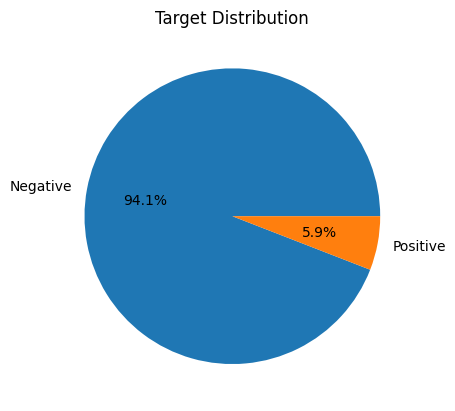

Number of positive examples: 106438 (5.90%)
Number of negative examples: 1698436 (94.10%)


In [147]:
import matplotlib.pyplot as plt

# Check if the data is balanced
target_counts = data['target'].value_counts()
fig, ax = plt.subplots()
ax.pie(target_counts, labels=target_counts.index.map({0: 'Negative', 1: 'Positive'}), autopct='%1.1f%%')
ax.set_title('Target Distribution')
plt.show()

# Check the number of positive and negative class
positive_data = data[data['target'] == 1]
negative_data = data[data['target'] == 0]
print(f'Number of positive examples: {len(positive_data)} ({len(positive_data)/len(data)*100:.2f}%)')
print(f'Number of negative examples: {len(negative_data)} ({len(negative_data)/len(data)*100:.2f}%)')


In [15]:
# choose a portion of negative class and create a balanced dataset
negative_data_sample = negative_data.sample(frac=postive_data.shape[0]/negative_data.shape[0])

train_data = pd.concat([postive_data,negative_data_sample],axis = 0)
train_data.shape

(212876, 2)

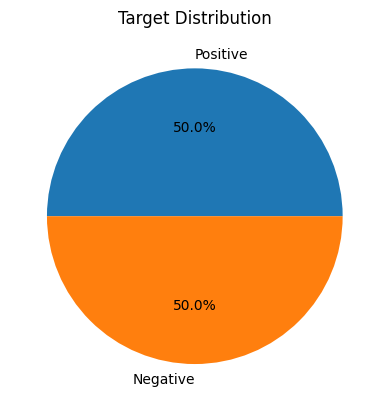

Number of positive examples: 106438 (5.90%)
Number of negative examples: 106438 (5.90%)


In [149]:
# Check if the data is balanced
target_counts = train_data['target'].value_counts()
fig, ax = plt.subplots()
ax.pie(target_counts, labels=target_counts.index.map({0: 'Negative', 1: 'Positive'}), autopct='%1.1f%%')
ax.set_title('Target Distribution')
plt.show()

# Check the number of positive and negative class
positive_data = train_data[train_data['target'] == 1]
negative_data = train_data[train_data['target'] == 0]
print(f'Number of positive examples: {len(positive_data)} ({len(positive_data)/len(data)*100:.2f}%)')
print(f'Number of negative examples: {len(negative_data)} ({len(negative_data)/len(data)*100:.2f}%)')

# Preprocess the data

In [150]:

def preprocess_text(text):
    # remove unwanted characters
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    # convert to lowercase
    text = text.lower()
    
    # tokenize the text into words
    words = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # stem the words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # join the words back into a string
    text = ' '.join(lemmatized_words)
    
    return text

In [24]:
# preposs the data
train_data_t = train_data.sample(frac = 1)
X = train_data_t['comment_text'].apply(preprocess_text)
y = train_data_t['target']

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_features,val_features,train_labels,val_labels = train_test_split(X,y,test_size=0.2)

# initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# fit the TfidfVectorizer on the train data
tfidf_vectorizer.fit(train_features)

# transform the text in the train and test data into feature vectors
train_features = tfidf_vectorizer.transform(train_features)
val_features = tfidf_vectorizer.transform(val_features)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# create a function to evaludate 
def evaluate(model, val_features, val_labels):
    preds = model.predict(val_features)
    acc = accuracy_score(val_labels, preds)
    prec = precision_score(val_labels, preds)
    recall = recall_score(val_labels, preds)
    f1 = f1_score(val_labels, preds)
    return acc, prec, recall, f1

# Train and evaluate logistic regression, naive Bayes, random forest, and SVM models

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import time
# Train and evaluate a logistic regression model
lr = LogisticRegression(max_iter= 500)
start_time = time.time()
lr.fit(train_features[:10000,:], train_labels[:10000])
end_time = time.time()
lr_train_time = end_time - start_time
lr_eval = evaluate(lr, val_features, val_labels)
lr_eval = lr_eval + (lr_train_time,)  # Add training time to evaluation results

# Train and evaluate a Naive Bayes model
nb = MultinomialNB()
start_time = time.time()
nb.fit(train_features[:10000,:], train_labels[:10000])
end_time = time.time()
nb_train_time = end_time - start_time
nb_eval = evaluate(nb, val_features, val_labels)
nb_eval = nb_eval + (nb_train_time,)  # Add training time to evaluation results

# Train and evaluate a random forest model
rf = RandomForestClassifier(n_estimators=100)
start_time = time.time()
rf.fit(train_features[:10000,:], train_labels[:10000])
end_time = time.time()
rf_train_time = end_time - start_time
rf_eval = evaluate(rf, val_features, val_labels)
rf_eval = rf_eval + (rf_train_time,)  # Add training time to evaluation results

# Train and evaluate an SVM model
svm = SVC(kernel='linear')
start_time = time.time()
svm.fit(train_features[:10000,:], train_labels[:10000])
end_time = time.time()
svm_train_time = end_time - start_time
svm_eval = evaluate(svm, val_features, val_labels)
svm_eval = svm_eval + (svm_train_time,)  # Add training time to evaluation results



In [153]:
result = pd.DataFrame(np.array([lr_eval, nb_eval, rf_eval, svm_eval]),
                      columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Time taken (s)'],
                      index=['Logistic regression', 'Naive Bayes', 'Random forest', 'SVM'])


result

,Accuracy,Precision,Recall,F1,Time taken (s)
Logistic regression,0.827508,0.856931,0.786526,0.820220,0.106007
Naive Bayes,0.785771,0.762875,0.829671,0.794872,0.005503
Random forest,0.826123,0.849540,0.792864,0.820224,53.947193
SVM,0.834437,0.860438,0.798592,0.828362,7.712046


In [160]:
from sklearn.model_selection import  GridSearchCV
# Define the parameter grid for logistic regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}
# Create a logistic regression classifier
clf = LogisticRegression()

# Perform cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=0)
grid_search.fit(train_features[:10000,:], train_labels[:10000])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model using the best hyperparameters
start = time.time()
clf = LogisticRegression(**best_params)
clf.fit(train_features, train_labels)
end = time.time()
log_time = end - start


In [164]:
# Evaluate the model on the validation set
log_result = evaluate(clf, val_features, val_labels) + (log_time,)
result = pd.DataFrame(log_result,index = ['Accuracy', 'Precision', 'Recall', 'F1','time_taken(s)'],columns = ['lr_all_train_tune'])
result['lr'] = lr_eval
result

,lr_all_train_tune,lr
Accuracy,0.881905,0.827508
Precision,0.895335,0.856931
Recall,0.865070,0.786526
F1,0.879943,0.820220
time_taken(s),1.264386,0.106007


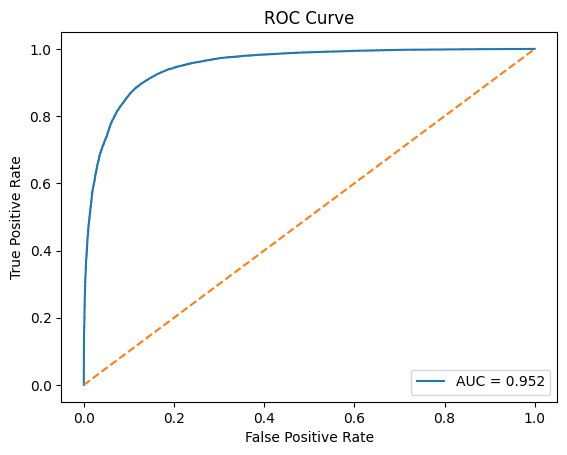

In [138]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_prob = clf.predict_proba(val_features)[:, 1]

# Compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(val_labels, y_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [139]:
f1_scores = [f1_score(val_labels, y_prob >= t) for t in thresholds]

# Choose the threshold that maximizes the F1 score
best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f'Best threshold: {best_threshold:.3f}')

Best threshold: 0.328


In [140]:
new_predict = np.where(y_prob > best_threshold,1,0)
accuracy_score(new_predict,val_labels)

0.8828682826005261

# Boostrap

In [144]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression classifier
logistic_reg = LogisticRegression(**best_params)

# Initialize bagging classifier with logistic regression as base estimator
bagging_clf = BaggingClassifier(base_estimator=logistic_reg, n_estimators=20)

# Fit the bagging classifier on the training data
bagging_clf.fit(train_features, train_labels)

bag_result = evaluate(bagging_clf, val_features, val_labels)
result = pd.DataFrame(bag_result,index = ['Accuracy', 'Precision', 'Recall', 'F1'],columns = ['LogisticRegression_bagging'])
result

c:\Users\RAIN\anaconda3\envs\tf_caonima\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,LogisticRegression_bagging
Accuracy,0.881060
Precision,0.896542
Recall,0.861690
F1,0.878770


In [ ]:
# Make predictions on the test data
y_pred = bagging_clf.predict(val_features)

# Evaluate the performance of the bagging classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Neural network

In [165]:
from tensorflow.keras.layers import Embedding, Dense, Flatten

# split the data into train and validation sets
train_text, val_text, train_target, val_target = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# tokenize the text and convert it to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)

# calculate the averge comment length
length = [len(x) for x in train_seq]
print('mean length',np.mean(length))
print('min length',np.min(length))
print('max length',np.max(length))

mean length 23.93336465061656
min length 0
max length 113


In [166]:
 # calculate the accuracy of each class
def postive_class(prediction,y_test):
    prediction = prediction.reshape(-1,1)
    pos_index = y_test == 1
    neg_index = y_test == 0
    pos_acc = sum(prediction[pos_index])/y_test[pos_index].shape[0]
    neg_acc = 1 - sum(prediction[neg_index])/y_test[neg_index].shape[0]
    return pos_acc,neg_acc

def evaluate_nn(preds, val_labels):
    acc = accuracy_score(val_labels, preds)
    prec = precision_score(val_labels, preds)
    recall = recall_score(val_labels, preds)
    f1 = f1_score(val_labels, preds)
    return acc, prec, recall, f1

In [167]:
# pad the sequences so they all have the same length

maxlen = 100
train_seq = pad_sequences(train_seq, maxlen=maxlen)
val_seq = pad_sequences(val_seq, maxlen=maxlen)
# create a nueral network model

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(100,activation= 'relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=1)

    start = time.time()
    # train the model
    history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])
    end = time.time()
    nn_time = end - start

    prediction = model.predict(val_seq)
    prediction = np.where(prediction>0.5,1,0).reshape(-1)
    result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')
nn_result = evaluate_nn(prediction,val_target) + (nn_time,)

Epoch 1/10
2661/2661 [==============================] - 5s 2ms/step - loss: 0.3285 - accuracy: 0.8575 - val_loss: 0.2809 - val_accuracy: 0.8863
Epoch 2/10
2661/2661 [==============================] - 4s 2ms/step - loss: 0.2237 - accuracy: 0.9117 - val_loss: 0.3059 - val_accuracy: 0.8796
positive class accuracy: [0.85790116]
negative class accuracy: [0.90121195]


# CNN

In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32, input_length=maxlen))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    start = time.time()
    history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])
    end = time.time()
    cnn_time = end - start

    prediction = model.predict(val_seq)
    prediction = np.where(prediction>0.5,1,0).reshape(-1)
    result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')
cnn_result = evaluate_nn(prediction,val_target) + (cnn_time,)

Epoch 1/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.3111 - accuracy: 0.8636 - val_loss: 0.2770 - val_accuracy: 0.8871
Epoch 2/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2438 - accuracy: 0.9020 - val_loss: 0.2714 - val_accuracy: 0.8900
Epoch 3/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2025 - accuracy: 0.9206 - val_loss: 0.2923 - val_accuracy: 0.8832
positive class accuracy: [0.87936866]
negative class accuracy: [0.8869316]


# LSTM

In [169]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
    model.add(LSTM(64, dropout=0.2,return_sequences=True))
    model.add(LSTM(32, dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train the model
    start = time.time()
    history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])
    end = time.time()
    lstm_time = end - start

prediction = model.predict(val_seq)
prediction = np.where(prediction>0.5,1,0).reshape(-1)
result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')
lstm_result = evaluate_nn(prediction,val_target) + (lstm_time,)

Epoch 1/10
2661/2661 [==============================] - 23s 8ms/step - loss: 0.3139 - accuracy: 0.8708 - val_loss: 0.2651 - val_accuracy: 0.8911
Epoch 2/10
2661/2661 [==============================] - 25s 9ms/step - loss: 0.2569 - accuracy: 0.9001 - val_loss: 0.2635 - val_accuracy: 0.8924
Epoch 3/10
2661/2661 [==============================] - 23s 9ms/step - loss: 0.2345 - accuracy: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.8894
positive class accuracy: [0.90849305]
negative class accuracy: [0.87039647]


In [170]:
result = pd.DataFrame(np.array([nn_result, cnn_result, lstm_result,log_result]),
                      columns=['Accuracy', 'Precision', 'Recall', 'F1','time taken(s)'],
                      index=['Neural Newtork','CNN','LSTM','logistic_regression'])


result

,Accuracy,Precision,Recall,F1,time taken(s)
Neural Newtork,0.879557,0.896740,0.857901,0.876891,9.350226
CNN,0.883150,0.886070,0.879369,0.882707,17.893144
LSTM,0.889445,0.875153,0.908493,0.891511,70.261034
logistic_regression,0.881905,0.895335,0.865070,0.879943,1.264386


In [171]:
print(result)

                     Accuracy  Precision    Recall        F1  time taken(s)
Neural Newtork       0.879557   0.896740  0.857901  0.876891       9.350226
CNN                  0.883150   0.886070  0.879369  0.882707      17.893144
LSTM                 0.889445   0.875153  0.908493  0.891511      70.261034
logistic_regression  0.881905   0.895335  0.865070  0.879943       1.264386


In [72]:
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [81]:

def evaluate_model(train_seq, train_target, val_seq, val_target, sample_size):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32, input_length=maxlen))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    start = time.time()
    history = model.fit(train_seq[:sample_size,:], train_target[:sample_size], validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 0, callbacks=[early_stopping])
    end = time.time()
    cnn_time = end - start

    prediction = model.predict(val_seq)
    prediction = np.where(prediction > 0.5, 1, 0).reshape(-1)

    return accuracy_score(val_target, prediction), cnn_time

# Sample sizes to test
sample_sizes = [10000, 30000, 50000, 70000, 100000, 130000, len(train_seq)]

results = []
for sample_size in sample_sizes:
    accuracy, time_taken = evaluate_model(train_seq, train_target, val_seq, val_target, sample_size)
    results.append((sample_size, accuracy, time_taken))

# Print results
for sample_size, accuracy, time_taken in results:
    print(f"Sample size: {sample_size}, Accuracy: {accuracy:.4f}, Time taken: {time_taken:.2f} seconds")

Sample size: 10000, Accuracy: 0.8374, Time taken: 3.69 seconds
Sample size: 30000, Accuracy: 0.8726, Time taken: 4.24 seconds
Sample size: 50000, Accuracy: 0.8745, Time taken: 6.01 seconds
Sample size: 70000, Accuracy: 0.8759, Time taken: 10.62 seconds
Sample size: 100000, Accuracy: 0.8776, Time taken: 13.04 seconds
Sample size: 130000, Accuracy: 0.8839, Time taken: 10.83 seconds
Sample size: 170300, Accuracy: 0.8829, Time taken: 20.95 seconds


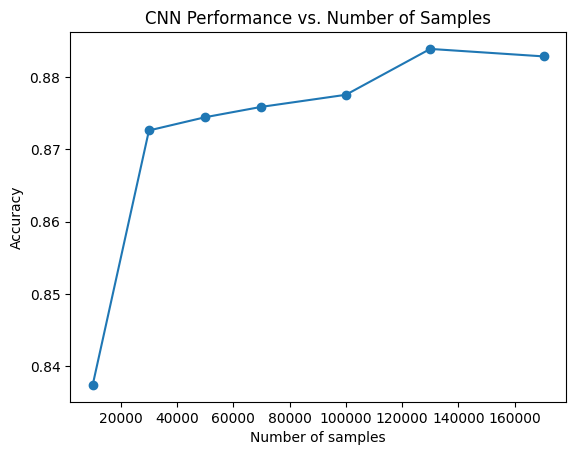

In [82]:
accuracies = [x[1] for x in results]
plt.plot(sample_sizes, accuracies, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('CNN Performance vs. Number of Samples')
plt.show()

# tune CNN

In [121]:
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
# Define the parameter grid
param_grid = {
    'filters': [32],
    'kernel_size': [5],
    'units': [64],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'learning_rate': [0.001,0.001, 0.01, 0.1]
}

# Create a new model instance
def create_model(filters, kernel_size, units, optimizer, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32, input_length=maxlen))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'))
    model.add(Conv1D(filters=filters*4, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_seq[:130000,:], train_target[:130000], validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose=0,callbacks=[early_stopping])

# Print the best parameters and score
print(f'Best parameters: {grid_result.best_params_}')
print(f'Best score: {grid_result.best_score_}')

Best parameters: {'filters': 32, 'kernel_size': 5, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
Best score: 0.8822999993960062


In [130]:
from sklearn.utils import resample

# Define the number of bootstrap samples
n_bootstrap = 10

# Create a new model with the best parameters
best_filters = grid_result.best_params_['filters']
best_kernel_size = grid_result.best_params_['kernel_size']
best_units = grid_result.best_params_['units']
best_optimizer = grid_result.best_params_['optimizer']
best_learning_rate = grid_result.best_params_['learning_rate']
best_model = create_model(best_filters, best_kernel_size, best_units, best_optimizer, best_learning_rate)

# Train the new model on the entire training set
best_model.fit(train_seq, train_target, epochs=10, validation_data=(val_seq, val_target),batch_size=64, verbose=1, callbacks=[early_stopping])

# Bootstrap to obtain multiple models and their validation accuracies
predictions = []
for i in range(n_bootstrap):
    # Resample the training set with replacement
    X_train_boot, y_train_boot = resample(train_seq, train_target)
    # Train a new model on the resampled training set
    model_boot = create_model(best_filters, best_kernel_size, best_units, best_optimizer, best_learning_rate)
    model_boot.fit(X_train_boot, y_train_boot, epochs=10, batch_size=64, verbose=0)
    y_pred = model_boot.predict(val_seq)
    predictions.append(y_pred)
mean_preds = np.mean(predictions, axis=0)
final_preds = np.round(mean_preds).astype(int)

evaluate_nn(final_preds,val_target)


Epoch 1/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.3112 - accuracy: 0.8626 - val_loss: 0.2705 - val_accuracy: 0.8900
Epoch 2/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2428 - accuracy: 0.9021 - val_loss: 0.2693 - val_accuracy: 0.8904
Epoch 3/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2007 - accuracy: 0.9216 - val_loss: 0.2928 - val_accuracy: 0.8823


(0.8867671927846674,
 0.8868217054263566,
 0.8866967305524239,
 0.8867592135860758)

In [133]:
ensemble = evaluate_nn(final_preds,val_target)
result = pd.DataFrame(ensemble,index = ['Accuracy', 'Precision', 'Recall', 'F1'],columns = ['cnn_ensemble'])
result

,cnn_ensemble
Accuracy,0.886767
Precision,0.886822
Recall,0.886697
F1,0.886759


# GloVe

In [172]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from gensim.models import KeyedVectors
from tensorflow.keras.optimizers import Adam,RMSprop,SGD

# Load pre-trained GloVe embeddings
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', binary=False)

# Tokenize the text and convert it to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)

# Pad the sequences so they all have the same length
maxlen = 100
train_seq = pad_sequences(train_seq, maxlen=maxlen)
val_seq = pad_sequences(val_seq, maxlen=maxlen)

# Map vocabulary to pre-trained embeddings
num_words = min(10000, len(tokenizer.word_index)+1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        break
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


# Create CNN model using pre-trained embeddings
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=maxlen, weights=[embedding_matrix]))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile and fit the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose=1, callbacks=[early_stopping])

prediction = model.predict(val_seq)
prediction = np.where(prediction>0.5,1,0).reshape(-1)
result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')

Epoch 1/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.3161 - accuracy: 0.8640 - val_loss: 0.2846 - val_accuracy: 0.8809
Epoch 2/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2488 - accuracy: 0.8995 - val_loss: 0.2670 - val_accuracy: 0.8913
Epoch 3/10
2661/2661 [==============================] - 6s 2ms/step - loss: 0.2228 - accuracy: 0.9114 - val_loss: 0.2772 - val_accuracy: 0.8885
positive class accuracy: [0.89764186]
negative class accuracy: [0.87932168]


In [174]:
glove = evaluate_nn(prediction,val_target)
result = pd.DataFrame(glove,index = ['Accuracy', 'Precision', 'Recall', 'F1'],columns = ['cnn_ensemble'])
result

,cnn_ensemble
Accuracy,0.888482
Precision,0.881493
Recall,0.897642
F1,0.889494


In [175]:
# get the word-to-index mappings
word_index = tokenizer.word_index

# get the probability of each word being toxic
weights = model.layers[0].get_weights()[0]
word_prob = dict(zip(word_index.keys(), weights[:, 0]))

# sort the words by the probability of being toxic
sorted_words = sorted(word_prob.items(), key=lambda x: x[1], reverse=True)

# print the top 20 most toxic words
for i in range(20):
    print(sorted_words[i])

('untrustworthi', 1.6873754)
('uncomfort', 1.5301968)
('boot', 1.505801)
('scratch', 1.4772482)
('mathemat', 1.4629576)
('railroad', 1.4444764)
('congreg', 1.4242818)
('accumul', 1.400033)
('ray', 1.3844199)
('effect', 1.3692124)
('given', 1.3606409)
('gomer', 1.3530343)
('requir', 1.3435355)
('scofflaw', 1.3414085)
('intox', 1.3394476)
('hart', 1.337225)
('pervas', 1.3231249)
('stake', 1.3137982)
('shambl', 1.3057103)
('frickin', 1.3044283)
